# Product Amount Forecast by Time

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

## Import Libraries

In [303]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

## Indest Data

In [304]:
df = pd.read_csv('Frozen_Dessert_Production.csv',
                 index_col='DATE',
                 parse_dates=True
                )

## Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Change the column name as "Production"
2. Plot your data and see its seasonalty

In [305]:
df

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


In [306]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [307]:
df.columns = ["Production"]
df.head(1)

,Production
DATE,
1972-01-01,59.962


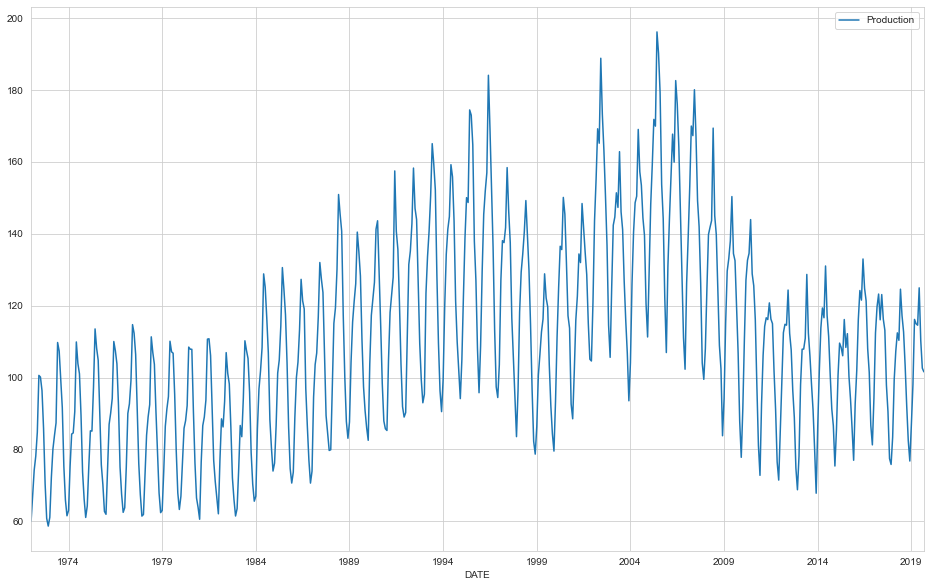

In [308]:
df.plot(figsize=(16,10));

## Preprocessing of Data

### Train Test Split

In [309]:
len(df)

573

In [310]:
test_size = 30

In [311]:
test_index = len(df)- test_size
test_index

543

In [312]:
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [313]:
train

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2016-11-01,86.665
2016-12-01,81.257
2017-01-01,94.245


In [314]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2017-04-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Production  30 non-null     float64
dtypes: float64(1)
memory usage: 480.0 bytes


### Scaling

In [315]:
from sklearn.preprocessing import MinMaxScaler

In [316]:
scaler = MinMaxScaler()

In [317]:
train_scale = scaler.fit_transform(train)
test_scale = scaler.transform(test)

## Time Series Generator

In [318]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [319]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scale, train_scale, length = length, batch_size = batch_size)

In [320]:
len(generator)

531

In [321]:
generator[0]

(array([[[0.00947104],
         [0.06108982],
         [0.11326273],
         [0.14145625],
         [0.18982663],
         [0.30495972],
         [0.30154406],
         [0.27416065],
         [0.19736841],
         [0.08532665],
         [0.01561588],
         [0.        ]]]),
 array([[0.01774221]]))

## Modelling & Model Performance

### Import related libraries

In [322]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

### Creating Model

### with "tanh" activation function

In [323]:
featur = train_scale.shape[1]
featur

1

In [324]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, featur)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [325]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 12, 100)           40800     
                                                                 
 lstm_15 (LSTM)              (None, 50)                30200     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [327]:
validation_generator = TimeseriesGenerator(test_scale, test_scale, length = length, batch_size = batch_size)

In [328]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                   )

Epoch 1/20
531/531 [==============================] - 13s 15ms/step - loss: 0.0227 - val_loss: 0.0204
Epoch 2/20
531/531 [==============================] - 7s 13ms/step - loss: 0.0052 - val_loss: 0.0027
Epoch 3/20
531/531 [==============================] - 7s 13ms/step - loss: 0.0047 - val_loss: 0.0022
Epoch 4/20
531/531 [==============================] - 7s 13ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 5/20
531/531 [==============================] - 7s 13ms/step - loss: 0.0048 - val_loss: 0.0029
Epoch 6/20
531/531 [==============================] - 7s 13ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 7/20
531/531 [==============================] - 7s 13ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 8/20
531/531 [==============================] - 7s 13ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 9/20
531/531 [==============================] - 7s 13ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 10/20
531/531 [==============================] - 7s 13ms/step - loss: 0.0033 - val_l

<AxesSubplot:>

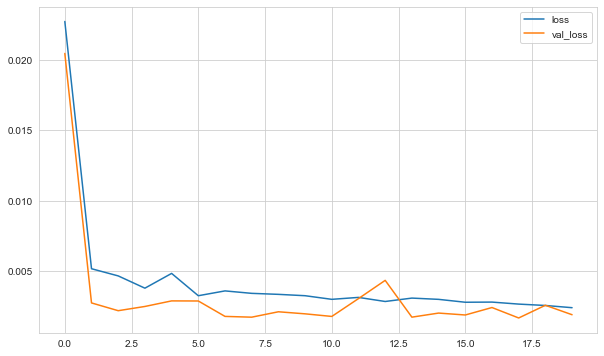

In [329]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [330]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [331]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [332]:
predictions_scaled = []

first_eval_batch = train_scale[-length:]
current_batch = first_eval_batch.reshape((1, length, featur))

for i in range(length):
    current_pred = model.predict(current_batch)    
    predictions_scaled.append(current_pred[0])    
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)
    
predictions_scaled

[array([0.45287615], dtype=float32),
 array([0.49112043], dtype=float32),
 array([0.51427543], dtype=float32),
 array([0.4702704], dtype=float32),
 array([0.38062418], dtype=float32),
 array([0.27658704], dtype=float32),
 array([0.18392095], dtype=float32),
 array([0.1294364], dtype=float32),
 array([0.15447262], dtype=float32),
 array([0.25165918], dtype=float32),
 array([0.3349497], dtype=float32),
 array([0.3678269], dtype=float32)]

In [333]:
test_scale[:length]

array([[0.4695409 ],
       [0.41743926],
       [0.46851409],
       [0.41889656],
       [0.39641011],
       [0.28544533],
       [0.23134679],
       [0.13655347],
       [0.12472921],
       [0.18015997],
       [0.29691617],
       [0.35382169]])

In [282]:
eval_metrics(test_scale[:length], predictions_scaled)

r2_score: 0.8599468812618718 
mae: 0.034585234422486684 
mse: 0.0019992445191772223 
rmse: 0.04471291221981881


#### Inverse Transformations and Comparing

In [301]:
predictions = scaler.inverse_transform(predictions_scaled)  #predict_tanh
predictions

array([[120.90512404],
       [123.04625437],
       [121.69754209],
       [116.0687658 ],
       [106.68966318],
       [ 96.70729238],
       [ 89.74531153],
       [ 85.09959903],
       [ 86.48285327],
       [ 95.84919604],
       [104.05154007],
       [109.77166188]])

In [334]:
compare = test[:12]

In [337]:
compare['predict_tanh'] = predictions

In [338]:
compare

,Production,predict_tanh
DATE,,
2017-04-01,123.228,120.905
2017-05-01,116.064,123.046
2017-06-01,123.087,121.698
2017-07-01,116.264,116.069
2017-08-01,113.172,106.690
2017-09-01,97.912,96.707
2017-10-01,90.473,89.745
2017-11-01,77.438,85.100
2017-12-01,75.812,86.483


<AxesSubplot:xlabel='DATE'>

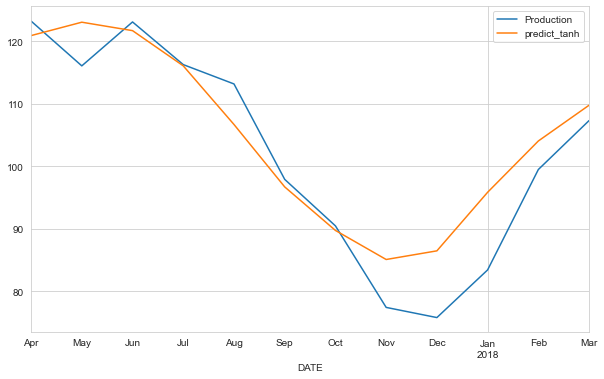

In [339]:
compare.plot()

#### Calculation R2 Score and Error Metrics

In [340]:
eval_metrics(compare.Production, compare.predict_tanh)

r2_score: 0.859946881261872 
mae: 4.7559504678503925 
mse: 37.80585918914289 
rmse: 6.148646939704937


In [341]:
compare

,Production,predict_tanh
DATE,,
2017-04-01,123.228,120.905
2017-05-01,116.064,123.046
2017-06-01,123.087,121.698
2017-07-01,116.264,116.069
2017-08-01,113.172,106.690
2017-09-01,97.912,96.707
2017-10-01,90.473,89.745
2017-11-01,77.438,85.100
2017-12-01,75.812,86.483


### with "relu" activation function

In [344]:
model_relu = Sequential()
model_relu.add(LSTM(100, activation = 'relu', return_sequences=True, input_shape = (length, featur)))
model_relu.add(LSTM(50, activation = 'relu'))
model_relu.add(Dense(1))
model_relu.compile(optimizer = 'adam', loss = 'mse')

In [345]:
model_relu.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                   )

Epoch 1/20
531/531 [==============================] - 10s 13ms/step - loss: 0.0249 - val_loss: 0.0204
Epoch 2/20
531/531 [==============================] - 6s 11ms/step - loss: 0.0110 - val_loss: 0.0021
Epoch 3/20
531/531 [==============================] - 6s 12ms/step - loss: 0.0071 - val_loss: 0.0020
Epoch 4/20
531/531 [==============================] - 6s 11ms/step - loss: 0.0070 - val_loss: 0.0029
Epoch 5/20
531/531 [==============================] - 6s 12ms/step - loss: 0.0059 - val_loss: 0.0015
Epoch 6/20
531/531 [==============================] - 6s 11ms/step - loss: 0.0060 - val_loss: 0.0026
Epoch 7/20
531/531 [==============================] - 6s 11ms/step - loss: 0.0046 - val_loss: 0.0015
Epoch 8/20
531/531 [==============================] - 6s 11ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 9/20
531/531 [==============================] - 6s 12ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 10/20
531/531 [==============================] - 6s 11ms/step - loss: 0.0033 - val_l

<AxesSubplot:>

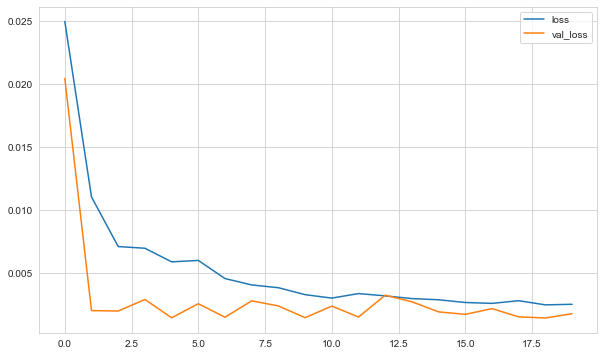

In [346]:
loss_df = pd.DataFrame(model_relu.history.history)
loss_df.plot()

In [347]:
predictions_relu = scaler.inverse_transform(predictions_scaled)
predictions_relu

array([[120.93656569],
       [126.1956854 ],
       [129.37982028],
       [123.32851611],
       [111.00091475],
       [ 96.69436245],
       [ 83.95148708],
       [ 76.45910465],
       [ 79.90193232],
       [ 93.26643596],
       [104.72003983],
       [109.24111276]])

#### Evaluate on Test Data

In [348]:
predictions_scaled = []

first_eval_batch = train_scale[-length:]
current_batch = first_eval_batch.reshape((1, length, featur))

for i in range(length):
    current_pred = model_relu.predict(current_batch)    
    predictions_scaled.append(current_pred[0])    
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)
    
predictions_scaled

[array([0.5024258], dtype=float32),
 array([0.54595375], dtype=float32),
 array([0.57652175], dtype=float32),
 array([0.5644282], dtype=float32),
 array([0.506557], dtype=float32),
 array([0.4139405], dtype=float32),
 array([0.33223355], dtype=float32),
 array([0.25052488], dtype=float32),
 array([0.2366981], dtype=float32),
 array([0.35173392], dtype=float32),
 array([0.43738598], dtype=float32),
 array([0.50365233], dtype=float32)]

In [349]:
eval_metrics(test_scale[:length], predictions_scaled)

r2_score: -0.08821013879121509 
mae: 0.12019018437369051 
mse: 0.01553409288770899 
rmse: 0.1246358411040299


#### Inverse Transformations and Comparing

In [350]:
predictions_relu = scaler.inverse_transform(predictions_scaled)
predictions_relu

array([[127.75032982],
       [133.73602947],
       [137.93955486],
       [136.27652446],
       [128.31842696],
       [115.58237105],
       [104.34653092],
       [ 93.11045309],
       [ 91.20907967],
       [107.02810351],
       [118.80645141],
       [127.91899672]])

In [351]:
compare['Pred_relu'] = predictions_relu

In [352]:
compare

,Production,predict_tanh,Pred_relu
DATE,,,
2017-04-01,123.228,120.905,127.750
2017-05-01,116.064,123.046,133.736
2017-06-01,123.087,121.698,137.940
2017-07-01,116.264,116.069,136.277
2017-08-01,113.172,106.690,128.318
2017-09-01,97.912,96.707,115.582
2017-10-01,90.473,89.745,104.347
2017-11-01,77.438,85.100,93.110
2017-12-01,75.812,86.483,91.209


<AxesSubplot:xlabel='DATE'>

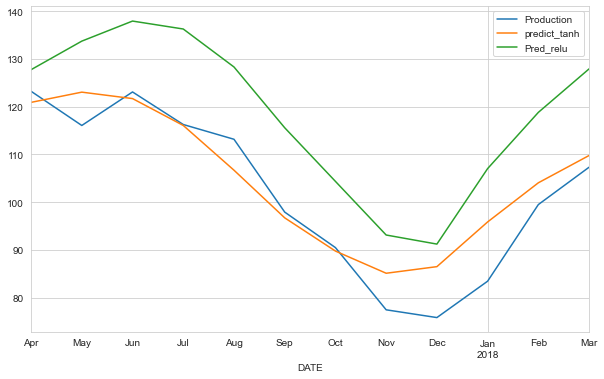

In [353]:
compare.plot()

#### Calculation R2 Score and Error Metrics

In [354]:
eval_metrics(compare.Production, compare.Pred_relu)

r2_score: -0.08821013879121398 
mae: 16.52782099494524 
mse: 293.75082572965334 
rmse: 17.139160589995456


tanh:

r2_score: 0.859946881261872 

mae: 4.7559504678503925 

mse: 37.80585918914289 

rmse: 6.148646939704937

## Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [360]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [361]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [362]:
len(df)

573

In [363]:
len(generator)

561

In [364]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, featur)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=15)

Epoch 1/15
561/561 [==============================] - 12s 13ms/step - loss: 0.0192
Epoch 2/15
561/561 [==============================] - 7s 13ms/step - loss: 0.0049
Epoch 3/15
561/561 [==============================] - 7s 13ms/step - loss: 0.0042
Epoch 4/15
561/561 [==============================] - 7s 13ms/step - loss: 0.0040
Epoch 5/15
561/561 [==============================] - 7s 13ms/step - loss: 0.0037
Epoch 6/15
561/561 [==============================] - 7s 13ms/step - loss: 0.0035
Epoch 7/15
561/561 [==============================] - 7s 13ms/step - loss: 0.0034
Epoch 8/15
561/561 [==============================] - 8s 14ms/step - loss: 0.0032
Epoch 9/15
561/561 [==============================] - 8s 15ms/step - loss: 0.0032
Epoch 10/15
561/561 [==============================] - 9s 16ms/step - loss: 0.0030
Epoch 11/15
561/561 [==============================] - 13s 23ms/step - loss: 0.0032
Epoch 12/15
561/561 [==============================] - 13s 23ms/step - loss: 0.0033
Epoch 13/1

In [365]:
scaled_full_data.shape

(573, 1)

In [366]:
scaled_full_data[-length:].shape

(12, 1)

In [367]:
forecast = []

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, featur))

for i in range(length):
    current_pred = model.predict(current_batch)
    forecast.append(current_pred[0]) 
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [368]:
forecast = scaler.inverse_transform(forecast)

In [369]:
forecast

array([[ 93.17945095],
       [ 90.9940556 ],
       [ 96.88924985],
       [106.52826245],
       [115.71006791],
       [123.43640211],
       [129.4702437 ],
       [132.81104175],
       [131.78223759],
       [125.67720968],
       [116.98005722],
       [108.34712818]])

In [370]:
df

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


In [371]:
forecast_index = pd.date_range(start = '2019-09-01', periods = length, freq = 'MS')

In [372]:
forecast_index

DatetimeIndex(['2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01'],
              dtype='datetime64[ns]', freq='MS')

In [373]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [374]:
forecast_df

,Forecast
2019-09-01,93.179
2019-10-01,90.994
2019-11-01,96.889
2019-12-01,106.528
2020-01-01,115.710
2020-02-01,123.436
2020-03-01,129.470
2020-04-01,132.811
2020-05-01,131.782
2020-06-01,125.677


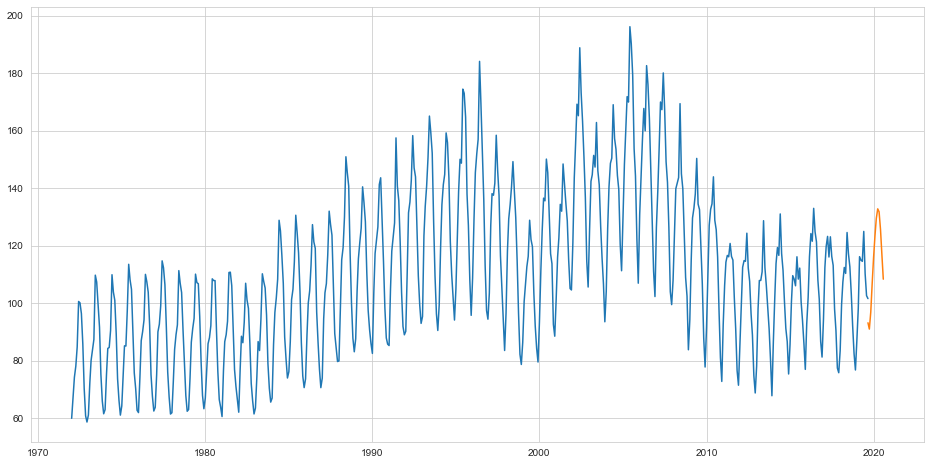

In [375]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['Production'])
plt.plot(forecast_df.index, forecast_df['Forecast'])

(548.0, 611.0)

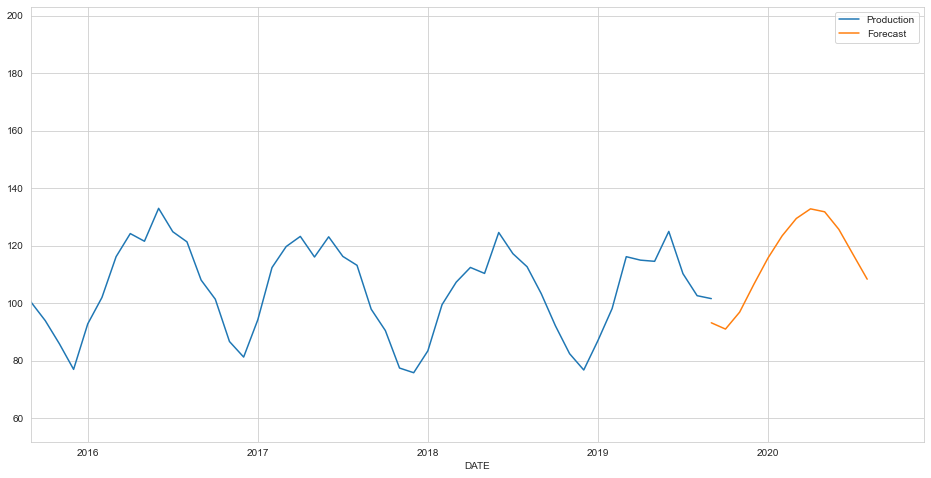

In [376]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2015-09-01', '2020-12-01')